GloVe-1.2/auto/iter40-xMax100/out-aladarV6a-300-15/vectors.txt

In [1]:
#import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = "" 

from tabulate import tabulate
from scipy.interpolate import interp1d
import numpy as np
import math
from MAPScorer import MAPScorer
from scipy import interp
from myLSTMFold0 import MyLSTM
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score, precision_recall_fscore_support, f1_score, accuracy_score, cohen_kappa_score
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 750 Ti (CNMeM is disabled, cuDNN not available)


In [2]:
outputPlotDir = "plots/lstm"

In [3]:
lstm = MyLSTM()
lstm.loadData()
lstm.loadModels()
#lstm.loadFineTuning3Model()

Load models


In [4]:
#tasks = ['sede1', 'sede12', 'sede2ft3', 'morfo1', 'morfo2']
#tasks = ['sede1', 'sede12', 'morfo1', 'morfo2']
tasks = ['sede12']
ftTasks = ['sede2ft3']
yp = {}
ycn = {}
yc = {}
ytn = {}
yt = {}
for task in tasks:
    print(task)
    yp[task] = lstm.model[task].predict_proba(lstm.XTest)
    #ycn[task] = lstm.model[task].predict_classes(lstm.XTest)
    ycn[task] = np.array([np.argmax(p) for p in yp[task]])
    yt[task] = lstm.yTest[task]
    
    ytn[task] = np.zeros_like(ycn[task])
    for i,v in enumerate(yt[task]):
        print("{} {}".format(task, i))
        ytn[task][i] = np.nonzero(yt[task][i])[0][0]
        
    yc[task] = np.zeros_like(yt[task])
    for i,v in enumerate(ycn[task]):
        yc[task][i][v] = 1
    
    #print("yt")
    #print(yt[task][0])
    #print("yp")
    #print(yp[task][0])
    #print("yc")
    #print(yc[task][0])
    #print("ytn")
    #print(ytn[task][0])
    #print("ycn")
    #print(ycn[task][0])

sede12
9440/9443 [============================>.] - ETA: 0s 

In [5]:
np.nonzero(yt['sede12'][870])

(array([89]),)

In [6]:
table = [["task", "average", "MAPs", "MAPc", "accuracy", "kappa", "precision", "recall", "f1score"]]
na = 'N/A'
metrics = {}
for task in tasks:
    table.append([" ", " ", " ", " ", " ", " ", " ", " "])
    metrics[task] = {}
    metrics[task][na] = {}
    metrics[task][na]['MAPs'] = MAPScorer().samplesScore(yt[task], yp[task])
    metrics[task][na]['MAPc'] = MAPScorer().classesScore(yt[task], yp[task])
    metrics[task][na]['accuracy'] = accuracy_score(yt[task], yc[task])
    metrics[task][na]['kappa'] = cohen_kappa_score(ytn[task], ycn[task])
    table.append([task, na, metrics[task][na]['MAPs'], metrics[task][na]['MAPc'], metrics[task][na]['accuracy'], metrics[task][na]['kappa'], na, na, na])
    for avg in ['micro', 'macro', 'weighted']:
        metrics[task][avg] = {}
        metrics[task][avg]['precision'], metrics[task][avg]['recall'], metrics[task][avg]['f1score'], metrics[task][avg]['support'] = precision_recall_fscore_support(yt[task], yc[task], average=avg)
        table.append([task, avg, na, na, na, na, metrics[task][avg]['precision'], metrics[task][avg]['recall'], metrics[task][avg]['f1score']])
print(tabulate(table))
        

------  --------  ------------------  -------------------  ------------------  ------------------  -------------------  -------------------  -------------------
task    average   MAPs                MAPc                 accuracy            kappa               precision            recall               f1score

sede12  N/A       0.8190251610615653  0.46998556547167286  0.7269935401884994  0.7120326563517319  N/A                  N/A                  N/A
sede12  micro     N/A                 N/A                  N/A                 N/A                 0.7269935401884994   0.7269935401884994   0.7269935401884994
sede12  macro     N/A                 N/A                  N/A                 N/A                 0.39832433654470467  0.38560802137028083  0.37038286036985363
sede12  weighted  N/A                 N/A                  N/A                 N/A                 0.709567558065567    0.7269935401884994   0.7095648623888255
------  --------  ------------------  -------------------  ----

/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [7]:
def _calculateMicroMacroCurve(curveFunction, yt, yp):
        n_classes = yt.shape[1]
        abscissa = dict()
        ordinate = dict()
        area = dict()
        for i in range(n_classes):
            abscissa[i], ordinate[i] = curveFunction(yt[:, i], yp[:, i])
            area[i] = auc(abscissa[i], ordinate[i])
        abscissa["micro"], ordinate["micro"] = curveFunction(yt.ravel(), yp.ravel())
        area["micro"] = auc(abscissa["micro"], ordinate["micro"])
        # aggregate all
        all_rec = list(filter(lambda x: not math.isnan(x), np.unique(np.concatenate([abscissa[i] for i in range(n_classes)]))))

        # interpolate all prec/rec curves at this points
        mean_ordinate = np.zeros_like(all_rec)
        representedClasses = 0
        unrepresentedClasses = 0
        for i in range(n_classes):
            interp = interp1d(abscissa[i], ordinate[i])
            curr_ordinate = interp(all_rec)
            if not np.any([math.isnan(x) for x in abscissa[i]]) and not np.any([math.isnan(x) for x in ordinate[i]]):
                mean_ordinate += curr_ordinate
                representedClasses += 1
            else:
                unrepresentedClasses += 1

        # average it and compute AUC
        mean_ordinate /= representedClasses

        abscissa["macro"] = all_rec
        ordinate["macro"] = mean_ordinate
        area["macro"] = auc(abscissa["macro"], ordinate["macro"])

        return (abscissa, ordinate, area)

In [8]:
rec = {}
pre = {}
pr_auc = {}
fpr = {}
tpr = {}
roc_auc = {}
for task in tasks:
    rec[task], pre[task], pr_auc[task] = _calculateMicroMacroCurve(lambda y,s: (lambda t: (t[1],t[0]))(precision_recall_curve(y,s)), yt[task], yp[task])
    fpr[task], tpr[task], roc_auc[task] = _calculateMicroMacroCurve(lambda y,s: (lambda t: (t[0],t[1]))(roc_curve(y,s)), yt[task], yp[task])

In [9]:
titles = {
    'sede1':'site', 
    'sede2':'subsite',
    'sede12':'full site', 
    'sede2ft':'subsite st',
    'sede2ft2':'subsite st',
    'sede2ft3':'full site st',
    'morfo1':'type',
    'morfo2':'behaviour',
    'morfo12':'type/behaviour',
    'morfo1ft4':'type st',
    'morfo1ft5':'type st',
    'morfo1ft6':'type st',
}

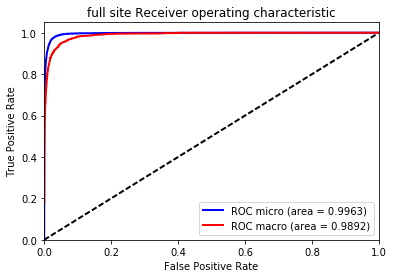

In [10]:
for task in tasks:
    fig = plt.figure()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(titles[task]+' Receiver operating characteristic')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    #for c in range(n_classes):
    #    plt.plot(fpr[c], tpr[c], lw=1, label='ROC curve {} (area = {:0.2f})'.format(c, roc_auc[2]))
    plt.plot(fpr[task]['micro'], tpr[task]['micro'], color='blue', lw=2, label='ROC micro (area = %0.4f)' % roc_auc[task]['micro'])
    plt.plot(fpr[task]['macro'], tpr[task]['macro'], color='red', lw=2, label='ROC macro (area = %0.4f)' % roc_auc[task]['macro'])
    plt.legend(loc="lower right")
    plt.savefig(outputPlotDir+"/roc-"+task+".pdf", bbox_inches='tight')
    plt.show()

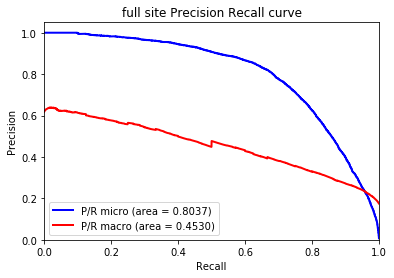

In [11]:
for task in tasks:
    fig = plt.figure()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
 
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(titles[task]+' Precision Recall curve')
    #for c in range(n_classes):
    #    plt.plot(fpr[c], tpr[c], lw=1, label='ROC curve {} (area = {:0.2f})'.format(c, roc_auc[2]))
    plt.plot(rec[task]['micro'], pre[task]['micro'], color='blue', lw=2, label='P/R micro (area = %0.4f)' % pr_auc[task]['micro'])
    plt.plot(rec[task]['macro'], pre[task]['macro'], color='red', lw=2, label='P/R macro (area = %0.4f)' % pr_auc[task]['macro'])
    plt.legend(loc="lower left")
    plt.savefig(outputPlotDir+"/pr-"+task+".pdf", bbox_inches='tight')
    plt.show()